In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Đọc dữ liệu
data = pd.read_csv(r"C:\Users\Admin\Downloads\AEP_hourly.csv")

# Xử lý cột thời gian
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values('Datetime')
observed_demand = data['AEP_MW'].values

# Chuẩn hóa dữ liệu
mean_demand = np.mean(observed_demand)
std_demand = np.std(observed_demand)
observed_demand = (observed_demand - mean_demand) / std_demand

# Kiểm tra và xử lý giá trị thiếu
if data['AEP_MW'].isnull().sum() > 0:
    print("Có giá trị thiếu, đang điền bằng trung bình...")
    data['AEP_MW'].fillna(data['AEP_MW'].mean(), inplace=True)
    observed_demand = (data['AEP_MW'].values - mean_demand) / std_demand

# Giới hạn số mẫu
n_samples = min(1000, len(observed_demand))
observed_demand = observed_demand[:n_samples]
time = np.arange(n_samples)

In [ ]:
#Khởi tạo lớp HMM
class HiddenMarkovModel:
    def __init__(self, n_states, n_iterations=100):
        self.n_states = n_states
        self.n_iterations = n_iterations
        self.transmat = None
        self.emission_means = None
        self.emission_vars = None
        self.initial_probs = None

#Khởi tạo tham số
    def initialize(self, observations):
        self.transmat = np.random.dirichlet(np.ones(self.n_states), self.n_states)  # Tổng mỗi hàng = 1
        self.initial_probs = np.ones(self.n_states) / self.n_states
        obs_mean, obs_std = np.mean(observations), np.std(observations)
        self.emission_means = np.linspace(obs_mean - obs_std, obs_mean + obs_std, self.n_states)  # Phân bố đều
        self.emission_vars = np.ones(self.n_states) * max(obs_std ** 2, 1e-6)

#Phân phối Gaussian
    def gaussian_emission(self, observation, state):
        mean = self.emission_means[state]
        var = max(self.emission_vars[state], 1e-6)
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((observation - mean) ** 2) / (2 * var))

#Thuật toán Forward
    def forward(self, observations):
        T = len(observations)
        alpha = np.zeros((T, self.n_states))
        for t in range(T):
            for j in range(self.n_states):
                if t == 0:
                    alpha[t, j] = self.initial_probs[j] * self.gaussian_emission(observations[t], j)
                else:
                    alpha[t, j] = sum(alpha[t-1, i] * self.transmat[i, j] for i in range(self.n_states))
                    alpha[t, j] *= self.gaussian_emission(observations[t], j)
            # Chuẩn hóa alpha
            if np.sum(alpha[t]) > 0:
                alpha[t] /= np.sum(alpha[t])
            else:
                alpha[t] = np.ones(self.n_states) / self.n_states  # Trường hợp xấu
        return alpha

#Thuật toán Backward
    def backward(self, observations):
        T = len(observations)
        beta = np.zeros((T, self.n_states))
        for t in range(T-1, -1, -1):
            for i in range(self.n_states):
                if t == T-1:
                    beta[t, i] = 1
                else:
                    beta[t, i] = sum(self.transmat[i, j] * self.gaussian_emission(observations[t+1], j) * 
                                     beta[t+1, j] for j in range(self.n_states))
            # Chuẩn hóa beta
            if np.sum(beta[t]) > 0:
                beta[t] /= np.sum(beta[t])
            else:
                beta[t] = np.ones(self.n_states) / self.n_states
        return beta

#Thuật toán Baum-Welch
    def baum_welch(self, observations):
        T = len(observations)
        self.initialize(observations)
        
        for iteration in range(self.n_iterations):
            alpha = self.forward(observations)
            beta = self.backward(observations)
            xi = np.zeros((T-1, self.n_states, self.n_states))
            gamma = np.zeros((T, self.n_states))
            
            for t in range(T):
                alpha_beta_sum = sum(alpha[t, j] * beta[t, j] for j in range(self.n_states)) + 1e-10
                for j in range(self.n_states):
                    gamma[t, j] = alpha[t, j] * beta[t, j] / alpha_beta_sum
            
            for t in range(T-1):
                denom = sum(alpha[t, i] * beta[t, i] for i in range(self.n_states)) + 1e-10
                for i in range(self.n_states):
                    for j in range(self.n_states):
                        xi[t, i, j] = (alpha[t, i] * self.transmat[i, j] * 
                                      self.gaussian_emission(observations[t+1], j) * beta[t+1, j]) / denom
            
            if np.any(np.isnan(gamma)) or np.any(np.isnan(xi)):
                print(f"Warning: gamma hoặc xi chứa NaN tại vòng lặp {iteration}. Dừng huấn luyện.")
                break

            # M-step
            self.initial_probs = gamma[0] / (np.sum(gamma[0]) + 1e-10)
            for i in range(self.n_states):
                denom_transmat = np.sum(gamma[:-1, i]) + 1e-10
                if denom_transmat < 1e-6:
                    denom_transmat = 1e-6
                transmat_update = np.sum(xi[:, i, :], axis=0) / denom_transmat
                # Chuẩn hóa để tổng bằng 1
                transmat_update = transmat_update / (np.sum(transmat_update) + 1e-10)
                self.transmat[i] = transmat_update
                
                denom_gamma = np.sum(gamma[:, i]) + 1e-10
                if denom_gamma < 1e-6:
                    denom_gamma = 1e-6
                self.emission_means[i] = sum(gamma[t, i] * observations[t] for t in range(T)) / denom_gamma
                
                if np.isnan(self.emission_means[i]):
                    self.emission_means[i] = np.mean(observations)
                self.emission_vars[i] = sum(gamma[t, i] * (observations[t] - self.emission_means[i]) ** 2 
                                           for t in range(T)) / denom_gamma
                self.emission_vars[i] = max(self.emission_vars[i], 1e-6)

#Thuật toán Viterbi
    def viterbi(self, observations):
        T = len(observations)
        V = np.zeros((T, self.n_states))
        path = np.zeros((T, self.n_states), dtype=int)
        
        for j in range(self.n_states):
            V[0, j] = np.log(self.initial_probs[j] + 1e-10) + \
                      np.log(self.gaussian_emission(observations[0], j) + 1e-10)
        
        for t in range(1, T):
            for j in range(self.n_states):
                probs = [V[t-1, i] + np.log(self.transmat[i, j] + 1e-10) + 
                         np.log(self.gaussian_emission(observations[t], j) + 1e-10) 
                         for i in range(self.n_states)]
                V[t, j] = max(probs)
                path[t, j] = np.argmax(probs)
        
        states = np.zeros(T, dtype=int)
        states[T-1] = np.argmax(V[T-1])
        for t in range(T-2, -1, -1):
            states[t] = path[t+1, states[t+1]]
        
        return states

In [ ]:
#Khởi tạo Particle Filter
class EnergyDemandParticleFilter:
    def __init__(self, n_particles, initial_state, state_noise, obs_noise):
        self.n_particles = n_particles
        self.particles = np.random.normal(initial_state, state_noise, n_particles)
        self.weights = np.ones(n_particles) / n_particles
        self.state_noise = state_noise
        self.obs_noise = obs_noise

    def predict(self):
        self.particles += np.random.normal(0, self.state_noise, self.n_particles)

    def update(self, observation):
        for i in range(self.n_particles):
            likelihood = np.exp(-0.5 * ((observation - self.particles[i]) / self.obs_noise) ** 2)
            self.weights[i] *= likelihood
        self.weights += 1e-10
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(np.arange(self.n_particles), size=self.n_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.n_particles) / self.n_particles

    def estimate(self):
        return np.average(self.particles, weights=self.weights)

In [ ]:
# Huấn luyện HMM
hmm_model = HiddenMarkovModel(n_states=3, n_iterations=50)  # Tăng số vòng lặp
hmm_model.baum_welch(observed_demand)
hidden_states = hmm_model.viterbi(observed_demand)

In [ ]:
# Áp dụng Particle Filter
n_particles = 500
pf = EnergyDemandParticleFilter(n_particles=n_particles, initial_state=observed_demand[0],
                                state_noise=0.1, obs_noise=0.2)

estimates = []
for t in range(len(observed_demand)):
    pf.predict()
    pf.update(observed_demand[t])
    pf.resample()
    estimates.append(pf.estimate())

In [ ]:
# Dự báo tương lai (10 bước)
n_forecast = 10
forecast = []
for _ in range(n_forecast):
    pf.predict()
    forecast.append(pf.estimate())
    pf.resample()

# Hoàn nguyên dữ liệu để trực quan hóa
estimates = np.array(estimates) * std_demand + mean_demand
forecast = np.array(forecast) * std_demand + mean_demand
observed_demand = observed_demand * std_demand + mean_demand

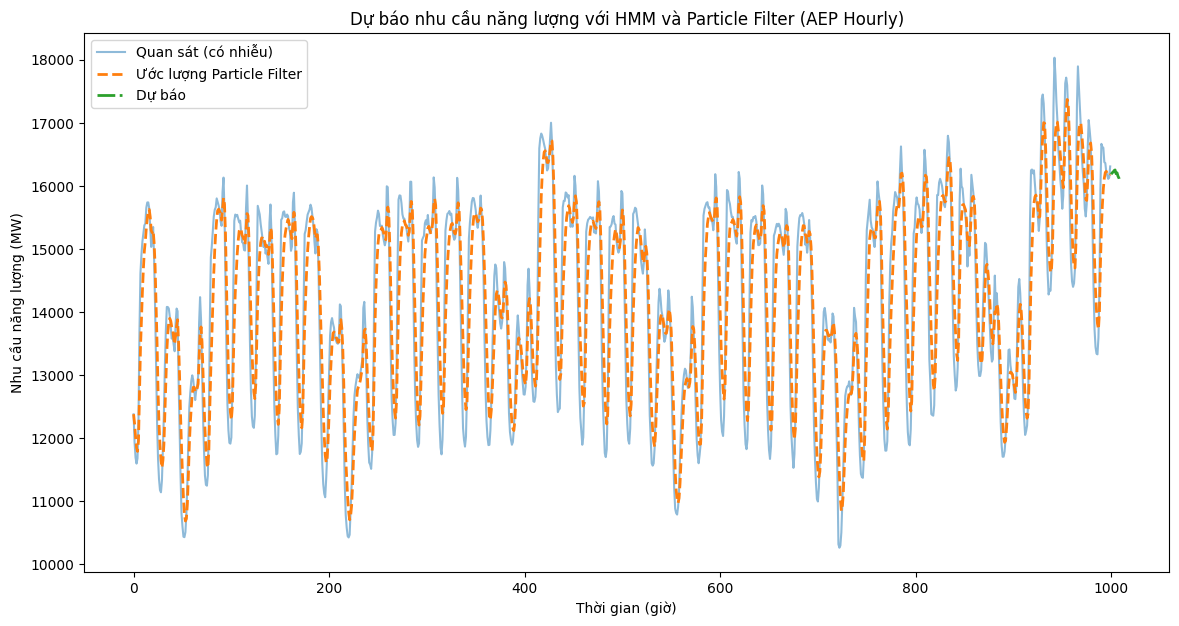

In [ ]:
# Vẽ kết quả
plt.figure(figsize=(14, 7))
plt.plot(time, observed_demand, label='Quan sát (có nhiễu)', alpha=0.5)
plt.plot(time, estimates, label='Ước lượng Particle Filter', linestyle='--', linewidth=2)
plt.plot(np.arange(n_samples, n_samples + n_forecast), forecast, label='Dự báo', linestyle='-.', linewidth=2)
plt.legend()
plt.title('Dự báo nhu cầu năng lượng với HMM và Particle Filter (AEP Hourly)')
plt.xlabel('Thời gian (giờ)')
plt.ylabel('Nhu cầu năng lượng (MW)')
plt.show()

In [ ]:
# In thông tin từ HMM
print("Trạng thái ẩn từ HMM (10 mẫu đầu):", hidden_states[:10])
print("Ma trận chuyển trạng thái HMM:")
for row in hmm_model.transmat:
    print("  ".join(f"{x:.4f}" for x in row))
print("Trung bình các trạng thái ẩn:")
print("  ".join(f"{x:.4f}" for x in hmm_model.emission_means * std_demand + mean_demand))  # Hoàn nguyên

Trạng thái ẩn từ HMM (10 mẫu đầu): [0 0 0 0 0 0 0 2 2 2]
Ma trận chuyển trạng thái HMM:
0.9054  0.0000  0.0946
1.0000  0.0000  0.0000
0.0000  0.0141  0.9859
Trung bình các trạng thái ẩn:
12705.2023  14365.9144  15605.2416


In [54]:
print("Tổng mỗi hàng transmat:", np.sum(hmm_model.transmat, axis=1))

Tổng mỗi hàng transmat: [1. 1. 1.]
